In [ ]:
# ETHZ model: Does CESM capture the extremes of observations / ERA5 / EObs
#
#
# Original: vikki.thompson 19/06/2023
# Last Editted 23/01/2025

In [19]:
### Load neccessary libraries
import subprocess
import numpy as np
import iris
import sys
import matplotlib.pyplot as plt
sys.path.append('/usr/people/thompson/WP1/boosting')
import functions_boosting as gboost

sys.path.append('/usr/people/thompson/WP1')
import functions_get_data as gdata
import functions_plot_data as pdata
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
from iris.util import equalise_attributes
from iris.util import unify_time_units
import warnings
warnings.filterwarnings("ignore")
from scipy.stats.stats import pearsonr
plt.ion(); plt.show()


In [20]:
## Variables
date = [2021, 'Jul', 14] # event date
R1 = [70, 30, 30, -30] # large analogues region


In [21]:
def ETHZ_data(var, region):
    '''
    var: 'PSL', 'Z500', 'pr_mm',
    '''
    filepath = '/net/pc200023/nobackup/users/thompson/ETHZ'
    files = sorted(glob.glob(filepath+'/'+var+'*'))
    latConstraint = iris.Constraint(latitude=lambda cell: region[1] < cell < region[0])
    lonConstraint = iris.Constraint(longitude=lambda cell: region[3] < cell < region[2])
    cube_list = iris.load(files).extract(latConstraint)
    # make -180 to 180
    new_cube_list = iris.cube.CubeList([])
    for each in cube_list:
        new_cube_list.append(roll_cube_180(each))
    # extract JJA
    jja_list = iris.cube.CubeList([])
    for each in new_cube_list:
        #iris.util.promote_aux_coord_to_dim_coord(each, 'time')
        each = each.extract(lonConstraint)
        iris.coord_categorisation.add_year(each, 'time')
        iris.coord_categorisation.add_month(each, 'time')
        iris.coord_categorisation.add_day_of_month(each, 'time')
        iris.coord_categorisation.add_season(each, 'time')
        jja_list.append(each.extract(iris.Constraint(season='jja')))
    return jja_list

In [22]:
pr = gboost.ETHZ_data('pr_mm', R1)

In [23]:
# Prepare CESM data
# merge each pair on pr into one full timeseries
for each in pr: iris.util.promote_aux_coord_to_dim_coord(each, 'time')

pr_ts = iris.cube.CubeList([])
for i in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 26, 28]: 
    new_list = iris.cube.CubeList([])
    new_list.append(pr[i])
    new_list.append(pr[i+1])
    equalise_attributes(new_list)
    unify_time_units(new_list)
    pr_ts.append(new_list.concatenate_cube())

for i, each in enumerate(pr_ts):
    print(i)
    ensemble_coord = iris.coords.AuxCoord(i, standard_name='realization', units="1")
    pr_ts[i].add_aux_coord(ensemble_coord)

pr_all = pr_ts.merge_cube()

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [24]:
# Extremes in CESM
ann_24max = pr_all.aggregated_by('year', iris.analysis.MAX)
ann_sum = pr_all.aggregated_by('year', iris.analysis.SUM)
ann_sum_ensmean = ann_sum.collapsed('realization', iris.analysis.MEAN)
ann_24max_ensmax = ann_24max.collapsed('realization', iris.analysis.MAX)

ann_max_24max_cesm = ann_24max_ensmax.collapsed('time', iris.analysis.MAX)
ann_sum_mean_cesm = ann_sum_ensmean.collapsed('time', iris.analysis.MEAN)
pr_daily_cesm = pr_all

In [25]:
# Extremes in ERA5
var = 'tp'; Y1=1950;  Y2=2025
years = np.arange(Y1, Y2)
all_yr_list = iris.cube.CubeList()
for yr in years:
    print(yr)
    files = glob.glob('/net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5/'+str(yr)+'/day/era5_*'+var+'.nc')
    yr_cubes = iris.load(files)
    rm_att = equalise_attributes(yr_cubes)
    unify_time_units(yr_cubes)
    new_cubes = iris.cube.CubeList()
    for each in yr_cubes:
        new_cubes.append(iris.util.squeeze(each))
        if len(new_cubes)>1 and new_cubes[-1].metadata!=new_cubes[0].metadata:
            new_cubes[-1].metadata = new_cubes[0].metadata
    yr_cube = new_cubes.concatenate_cube()
    yr_cube.rename('Precipitation')
    yr_cube.cell_methods = ''
    all_yr_list.append(yr_cube)

equalise_attributes(all_yr_list)
unify_time_units(all_yr_list)
pr_daily = all_yr_list.concatenate_cube()

iris.coord_categorisation.add_year(pr_daily, 'time')
iris.coord_categorisation.add_season(pr_daily, 'time')
pr_daily = pr_daily.extract(iris.Constraint(season='jja'))
ann_24max = pr_daily.aggregated_by('year', iris.analysis.MAX)
ann_sum = pr_daily.aggregated_by('year', iris.analysis.SUM)
ann_max_24max_era = ann_24max.collapsed('time', iris.analysis.MAX)
ann_sum_mean_era = ann_sum.collapsed('time', iris.analysis.MEAN)

pr_daily_era = gdata.extract_region(pr_daily, R1)
ann_sum_mean_era = gdata.extract_region(ann_sum_mean_era, R1)
ann_max_24max_era = gdata.extract_region(ann_max_24max_era, R1)

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [26]:
# Extremes in EObs
Y1=1950;  Y2=2025
file = '/net/pc230042/nobackup_1/users/sager/ClimateExplorer/sandbox/ENSEMBLES/rr_0.25deg_reg_v30.0eu.nc'
eobs_cube = iris.load(file)[0]
iris.coord_categorisation.add_year(eobs_cube, 'time')
iris.coord_categorisation.add_season(eobs_cube, 'time')
eobs_cube = eobs_cube.extract(iris.Constraint(season='jja'))
eobs_cube = eobs_cube.extract(iris.Constraint(year=lambda cell: Y1<=cell<Y2))
eobs_ann_24max = eobs_cube.aggregated_by('year', iris.analysis.MAX)
eobs_ann_sum = eobs_cube.aggregated_by('year', iris.analysis.SUM)
ann_max_24max_eobs = eobs_ann_24max.collapsed('time', iris.analysis.MAX)
ann_sum_mean_eobs = eobs_ann_sum.collapsed('time', iris.analysis.MEAN)

pr_daily_eobs = gdata.extract_region(eobs_cube, R1)
ann_sum_mean_eobs = gdata.extract_region(ann_sum_mean_eobs, R1)
ann_max_24max_eobs = gdata.extract_region(ann_max_24max_eobs, R1)

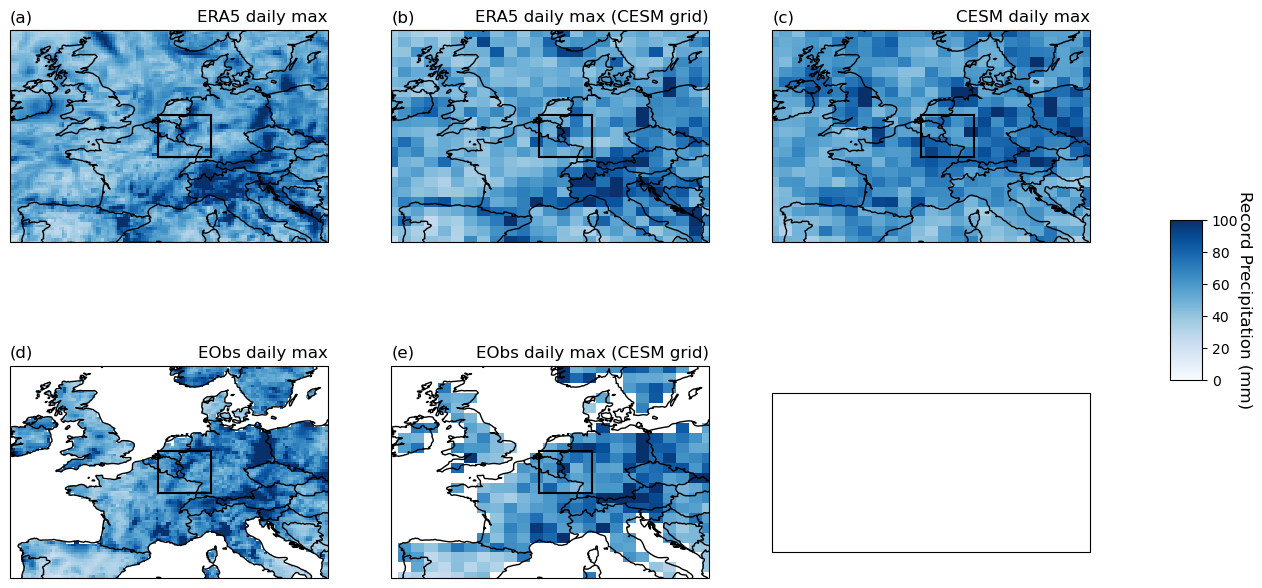

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16,8))
lats=ann_max_24max_era.coord('latitude').points
lons=ann_max_24max_era.coord('longitude').points
conlev = np.linspace(1, 120, 9)
c = axs[0,0].pcolormesh(lons, lats, ann_max_24max_era.data, vmin=0, vmax=100, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[0,0].set_title('(a)', loc='left')
axs[0,0].set_title('ERA5 daily max', loc='right')

lats=ann_max_24max_eobs.coord('latitude').points
lons=ann_max_24max_eobs.coord('longitude').points
c = axs[1,0].pcolormesh(lons, lats, ann_max_24max_eobs.data, vmin=0, vmax=100, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[1,0].set_title('(d)', loc='left')
axs[1,0].set_title('EObs daily max', loc='right')

ann_max_24max_era5_cesmgrid = gdata.regrid(ann_max_24max_era, ann_max_24max_cesm)
lats=ann_max_24max_cesm.coord('latitude').points
lons=ann_max_24max_cesm.coord('longitude').points
c = axs[0,1].pcolormesh(lons, lats, ann_max_24max_era5_cesmgrid.data, vmin=0, vmax=100, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[0,1].set_title('(b)', loc='left')
axs[0,1].set_title('ERA5 daily max (CESM grid)', loc='right') 

c = axs[0,2].pcolormesh(lons, lats, ann_max_24max_cesm.data, vmin=0, vmax=100, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 120, 20))
cbar_ax.set_ylabel('Record Precipitation (mm)', labelpad=10, rotation=270, fontsize=12)
axs[0,2].set_title('(c)', loc='left')
axs[0,2].set_title('CESM daily max', loc='right')

ann_max_24max_eobs_cesmgrid = gdata.regrid(ann_max_24max_eobs, ann_max_24max_cesm)
c = axs[1,1].pcolormesh(lons, lats, ann_max_24max_eobs_cesmgrid.data, vmin=0, vmax=100, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[1,1].set_title('(e)', loc='left')
axs[1,1].set_title('EObs daily max (CESM grid)', loc='right') 

for each in [axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1]]:
    each.add_feature(cf.BORDERS)
    each.add_feature(cf.COASTLINE)
    each.set_ylim([40, 60])
    each.set_xlim([-10, 20])
    pdata.plot_box(each, [48, 52, 4, 9])

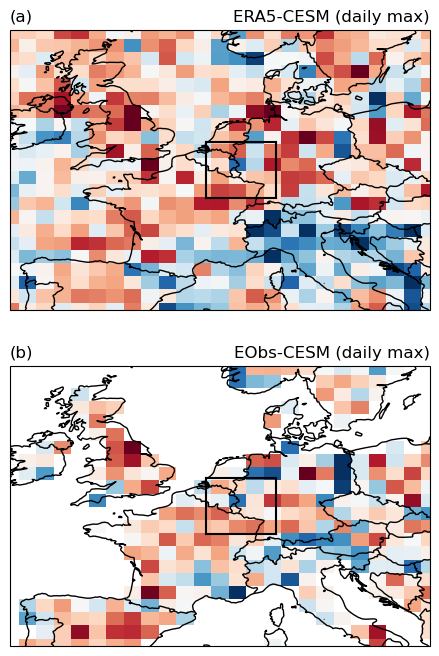

In [28]:
# Plot differences (ERA-CESM and EObs-CESM)
fig, axs = plt.subplots(nrows=2, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16,8))
lats=ann_max_24max_cesm.coord('latitude').points
lons=ann_max_24max_cesm.coord('longitude').points

c = axs[0].pcolormesh(lons, lats, (ann_max_24max_era5_cesmgrid-ann_max_24max_cesm).data, vmin=-50, vmax=50, cmap = plt.cm.get_cmap('RdBu'), transform=ccrs.PlateCarree())
axs[0].set_title('(a)', loc='left')
axs[0].set_title('ERA5-CESM (daily max)', loc='right')

c = axs[1].pcolormesh(lons, lats, (ann_max_24max_eobs_cesmgrid.data-ann_max_24max_cesm.data), vmin=-50, vmax=50, cmap = plt.cm.get_cmap('RdBu'), transform=ccrs.PlateCarree())
axs[1].set_title('(b)', loc='left')
axs[1].set_title('EObs-CESM (daily max)', loc='right')

for each in [axs[0], axs[1]]:
    each.add_feature(cf.BORDERS)
    each.add_feature(cf.COASTLINE)
    each.set_ylim([40, 60])
    each.set_xlim([-10, 20])
    pdata.plot_box(each, [48, 52, 4, 9])


In [ ]:
# 99th percentiles
cesm_99=np.percentile(pr_daily_cesm.data, 99, axis=[0,1]) 

era_99=np.percentile(pr_daily_era.data, 99, axis=0) 
era_cesmgrid_99=np.percentile(gdata.regrid(pr_daily_era, pr_daily_cesm).data, 99, axis=0) 

eobs_99=np.percentile(pr_daily_eobs.data, 99, axis=0) 
eobs_cesmgrid_99=np.percentile(gdata.regrid(pr_daily_eobs, pr_daily_cesm).data, 99, axis=0) 

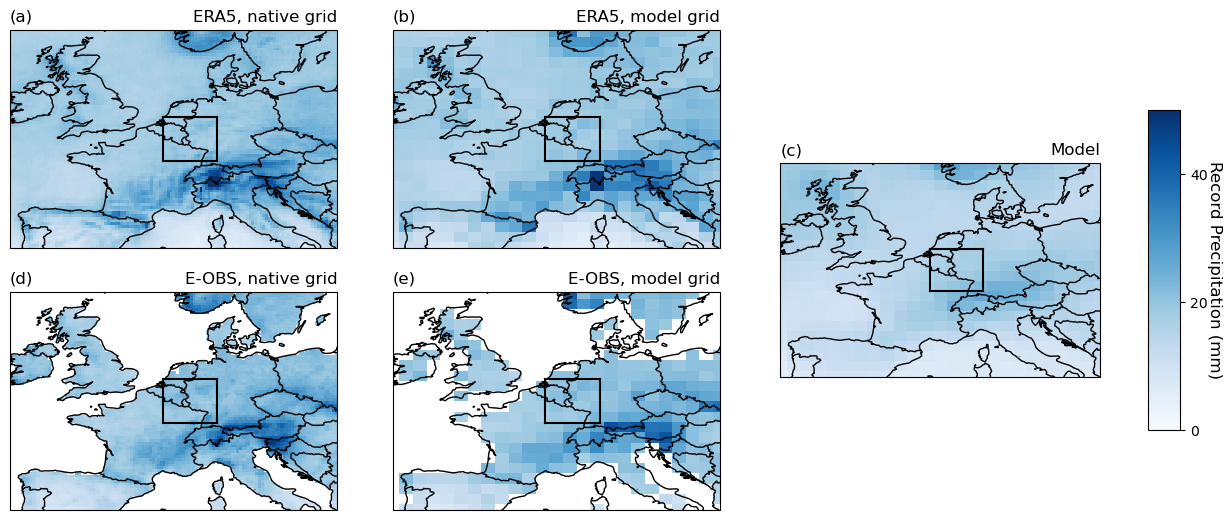

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16,8))
lats=ann_max_24max_era.coord('latitude').points
lons=ann_max_24max_era.coord('longitude').points
V1 = 0; V2 = 50
c = axs[0,0].pcolormesh(lons, lats, era_99, vmin=V1, vmax=V2, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[0,0].set_title('(a)', loc='left')
axs[0,0].set_title('ERA5, native grid', loc='right')

lats=ann_max_24max_eobs.coord('latitude').points
lons=ann_max_24max_eobs.coord('longitude').points
c = axs[1,0].pcolormesh(lons, lats, eobs_99, vmin=V1, vmax=V2, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[1,0].set_title('(d)', loc='left')
axs[1,0].set_title('E-OBS, native grid', loc='right')

lats=ann_max_24max_cesm.coord('latitude').points
lons=ann_max_24max_cesm.coord('longitude').points
c = axs[0,1].pcolormesh(lons, lats, era_cesmgrid_99, vmin=V1, vmax=V2, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[0,1].set_title('(b)', loc='left')
axs[0,1].set_title('ERA5, model grid', loc='right') 

c = axs[0,2].pcolormesh(lons, lats, cesm_99, vmin=V1, vmax=V2, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.78, 0.3, 0.02, 0.4])
fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 120, 20))
cbar_ax.set_ylabel('Record Precipitation (mm)', labelpad=10, rotation=270, fontsize=12)
axs[0,2].set_title('(c)', loc='left')
axs[0,2].set_title('Model', loc='right')

c = axs[1,1].pcolormesh(lons, lats, eobs_cesmgrid_99, vmin=V1, vmax=V2, cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree())
axs[1,1].set_title('(e)', loc='left')
axs[1,1].set_title('E-OBS, model grid', loc='right') 

axs[1,2].set_visible(False)

for each in [axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1]]:
    each.add_feature(cf.BORDERS)
    each.add_feature(cf.COASTLINE)
    each.set_ylim([40, 60])
    each.set_xlim([-10, 20])
    pdata.plot_box(each, [48, 52, 4, 9])

    
plt.subplots_adjust(top = .8, bottom = .2, right = .82, left = 0, 
            hspace = 0.2, wspace = -.3)

axs[0,2].set_position([0.55,0.35,0.2,0.3])


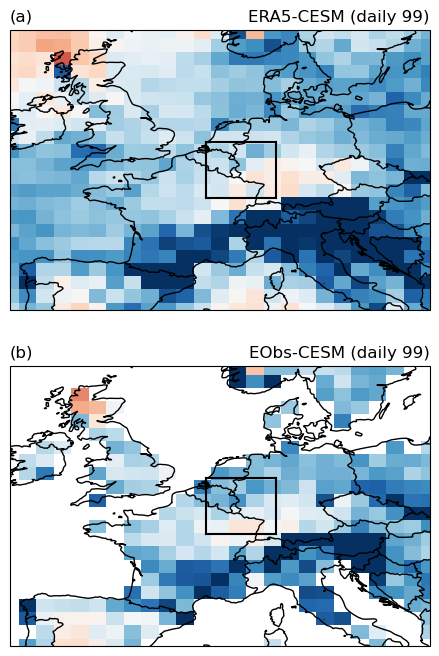

In [ ]:
# Plot differences (ERA-CESM and EObs-CESM)
fig, axs = plt.subplots(nrows=2, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16,8))
lats=ann_max_24max_cesm.coord('latitude').points
lons=ann_max_24max_cesm.coord('longitude').points
V1 = -10; V2 = 10
c = axs[0].pcolormesh(lons, lats, era_cesmgrid_99-cesm_99, vmin=V1, vmax=V2, cmap = plt.cm.get_cmap('RdBu'), transform=ccrs.PlateCarree())
axs[0].set_title('(a)', loc='left')
axs[0].set_title('ERA5-CESM (daily 99)', loc='right')

c = axs[1].pcolormesh(lons, lats, eobs_cesmgrid_99-cesm_99, vmin=V1, vmax=V2, cmap = plt.cm.get_cmap('RdBu'), transform=ccrs.PlateCarree())
axs[1].set_title('(b)', loc='left')
axs[1].set_title('EObs-CESM (daily 99)', loc='right')

for each in [axs[0], axs[1]]:
    each.add_feature(cf.BORDERS)
    each.add_feature(cf.COASTLINE)
    each.set_ylim([40, 60])
    each.set_xlim([-10, 20])
    pdata.plot_box(each, [48, 52, 4, 9])

In [ ]:
# Extract areal mean rainfall for the region (as in Fig.1) for every (JJA) day in CESM, ERA5, EObs. 
rain_region = [52, 48, 9, 4]
rain_cesm= gboost.extract_region(pr_daily_cesm, rain_region)
rain_era = gboost.extract_region(pr_daily_era, rain_region)
rain_era_cesmgrid = gdata.regrid(rain_era, rain_cesm)
rain_eobs = gboost.extract_region(pr_daily_eobs, rain_region)
rain_eobs_cesmgrid = gdata.regrid(rain_eobs, rain_cesm)

cesm_rain_mean = rain_cesm.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).data
cesm_rain_max = rain_cesm.collapsed(['latitude', 'longitude'], iris.analysis.MAX).data
era_rain_mean = rain_era_cesmgrid.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).data
era_rain_max = rain_era_cesmgrid.collapsed(['latitude', 'longitude'], iris.analysis.MAX).data
eobs_rain_mean = rain_eobs_cesmgrid.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).data
eobs_rain_max = rain_eobs_cesmgrid.collapsed(['latitude', 'longitude'], iris.analysis.MAX).data

# Reshape to match obs (concatenate ensembles)
cesm_rain_mean = np.reshape(cesm_rain_mean, (14*2852))
cesm_rain_max = np.reshape(cesm_rain_max, (14*2852))

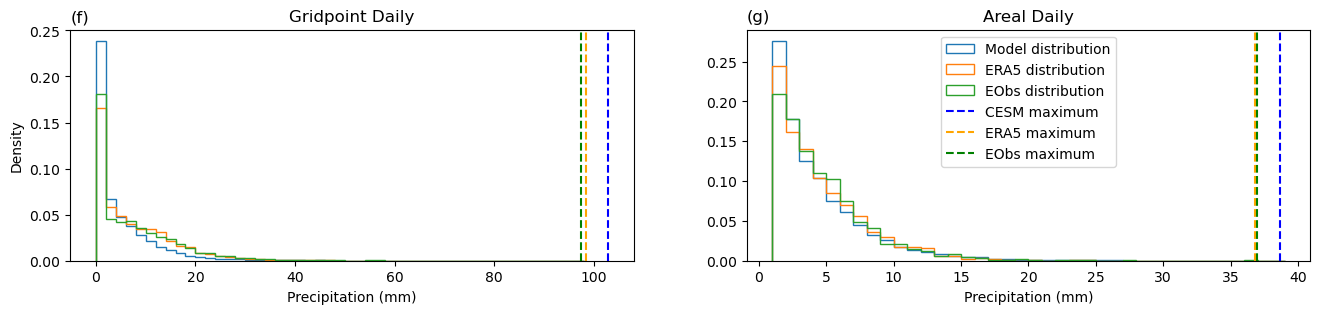

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,3))

# Plot distributions of rainfall
axs[0].hist(cesm_rain_max, bins=np.arange(0, 100, 2), density=True, histtype='step', label = 'Model')
axs[0].hist(era_rain_max, bins=np.arange(0, 100, 2), density=True, histtype='step', label = 'ERA5')
axs[0].hist(eobs_rain_max, bins=np.arange(0, 100, 2), density=True, histtype='step', label = 'EObs')
axs[0].set_title('Gridpoint Daily')
axs[0].set_title('(a)', loc='left')
axs[0].set_xlabel('Precipitation (mm)')
axs[0].set_ylabel('Density')
axs[0].axvline(np.max(cesm_rain_max), color='b', linestyle='--')
axs[0].axvline(np.max(era_rain_max), color='orange', linestyle='--')
axs[0].axvline(np.max(eobs_rain_max), color='g', linestyle='--')

# Plot distributions of rainfall
axs[1].hist(cesm_rain_mean, bins=np.arange(1, 40), density=True, histtype='step', label='Model distribution')
axs[1].hist(era_rain_mean, bins=np.arange(1, 40), density=True, histtype='step', label='ERA5 distribution')
axs[1].hist(eobs_rain_mean, bins=np.arange(1, 40), density=True, histtype='step', label='EObs distribution')
axs[1].set_title('Areal Daily')
axs[1].set_title('(b)', loc='left')
axs[1].set_xlabel('Precipitation (mm)')
axs[1].axvline(np.max(cesm_rain_mean), color='b', linestyle='--', label='CESM maximum')
axs[1].axvline(np.max(era_rain_mean), color='orange', linestyle='--', label='ERA5 maximum')
axs[1].axvline(np.max(eobs_rain_mean), color='g', linestyle='--', label='EObs maximum')
axs[1].legend(loc=9)

In [ ]:
# Annual max data
rain_era_mean_annual = rain_era.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).aggregated_by('year', iris.analysis.MAX)
rain_cesm_mean_annual = rain_cesm.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).aggregated_by('year', iris.analysis.MAX)
rain_eobs_mean_annual = rain_eobs.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).aggregated_by('year', iris.analysis.MAX)

rain_era_max_annual = rain_era_cesmgrid.collapsed(['latitude', 'longitude'], iris.analysis.MAX).aggregated_by('year', iris.analysis.MAX)
rain_cesm_max_annual = rain_cesm.collapsed(['latitude', 'longitude'], iris.analysis.MAX).aggregated_by('year', iris.analysis.MAX)
rain_eobs_max_annual = rain_eobs_cesmgrid.collapsed(['latitude', 'longitude'], iris.analysis.MAX).aggregated_by('year', iris.analysis.MAX)

E1 = np.sort(rain_era_mean_annual.data)
O1 = np.sort(rain_eobs_mean_annual.data)
M1 = np.sort(rain_cesm_mean_annual.data.reshape(14*31))

E2 = np.sort(rain_era_max_annual.data)
O2 = np.sort(rain_eobs_max_annual.data)
M2 = np.sort(rain_cesm_max_annual.data.reshape(14*31))

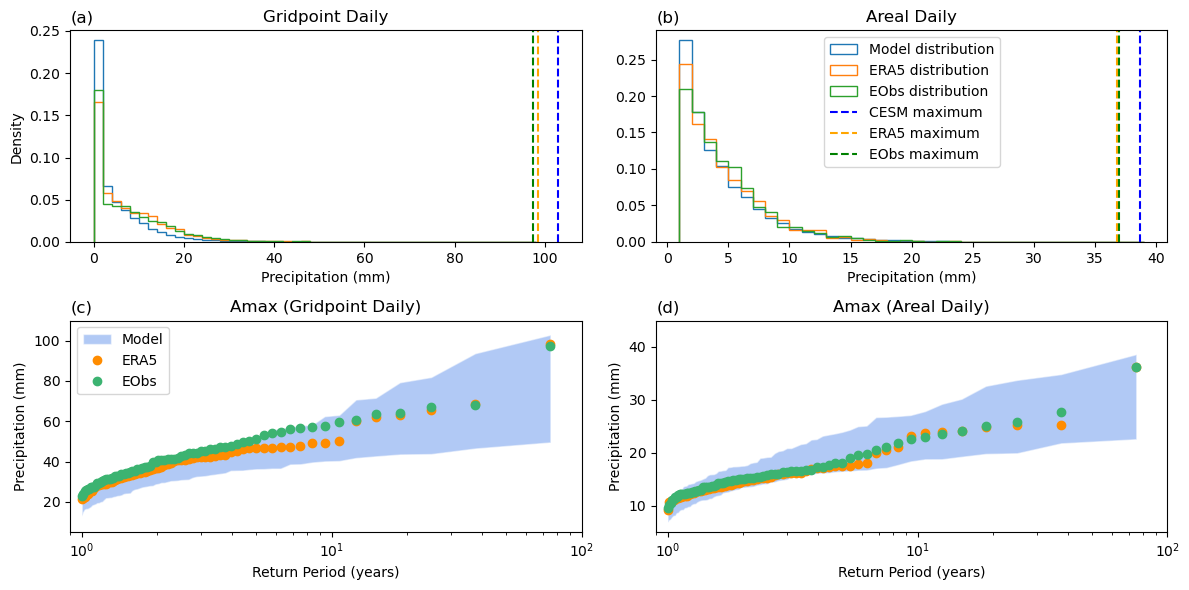

In [ ]:
import random
def plot_points(data_array):
    obs_sort = np.sort(data_array)
    chance = []
    for i in range(len(obs_sort)):
        chance.append(((i+1) / len(obs_sort)) * 100)
    ret_per = []
    for each in chance:
        ret_per.append(100.*1/each)
    ret_per.reverse()
    return(ret_per, obs_sort)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,5))

# Plot distributions of rainfall
axs[0,0].hist(cesm_rain_max, bins=np.arange(0, 100, 2), density=True, histtype='step', label = 'Model')
axs[0,0].hist(era_rain_max, bins=np.arange(0, 100, 2), density=True, histtype='step', label = 'ERA5')
axs[0,0].hist(eobs_rain_max, bins=np.arange(0, 100, 2), density=True, histtype='step', label = 'EObs')
axs[0,0].set_title('Gridpoint Daily')
axs[0,0].set_title('(a)', loc='left')
axs[0,0].set_xlabel('Precipitation (mm)')
axs[0,0].set_ylabel('Density')
axs[0,0].axvline(np.max(cesm_rain_max), color='b', linestyle='--')
axs[0,0].axvline(np.max(era_rain_max), color='orange', linestyle='--')
axs[0,0].axvline(np.max(eobs_rain_max), color='g', linestyle='--')

# Plot distributions of rainfall
axs[0,1].hist(cesm_rain_mean, bins=np.arange(1, 40), density=True, histtype='step', label='Model distribution')
axs[0,1].hist(era_rain_mean, bins=np.arange(1, 40), density=True, histtype='step', label='ERA5 distribution')
axs[0,1].hist(eobs_rain_mean, bins=np.arange(1, 40), density=True, histtype='step', label='EObs distribution')
axs[0,1].set_title('Areal Daily')
axs[0,1].set_title('(b)', loc='left')
axs[0,1].set_xlabel('Precipitation (mm)')
axs[0,1].axvline(np.max(cesm_rain_mean), color='b', linestyle='--', label='CESM maximum')
axs[0,1].axvline(np.max(era_rain_mean), color='orange', linestyle='--', label='ERA5 maximum')
axs[0,1].axvline(np.max(eobs_rain_mean), color='g', linestyle='--', label='EObs maximum')
axs[0,1].legend(loc=9)

axs[1,0].set_xscale('log') 
mod_sort_all = []
for i in np.arange(10000):
    S = random.sample(M2.data.data, len(E2))
    ret_per, mod_sort = plot_points(S)
    mod_sort_all.append(mod_sort)

axs[1,0].fill_between(ret_per, np.max(mod_sort_all, axis=0), np.min(mod_sort_all, axis=0), 
    facecolor='cornflowerblue', alpha=.5, edgecolor='white', label='Model')
ret_per, era_sort = plot_points(E2)
axs[1,0].plot(ret_per, era_sort, 'o', color='darkorange', label='ERA5')
ret_per, obs_sort = plot_points(O2)
axs[1,0].plot(ret_per, obs_sort, 'o', color='mediumseagreen', label='EObs')
axs[1,0].set_ylim([5, 110])
axs[1,0].set_xlim([.9, 2E2])
axs[1,0].set_title('Amax (Gridpoint Daily)')
axs[1,0].set_ylabel('Precipitation (mm)')
axs[1,0].set_xlabel('Return Period (years)')
axs[1,0].legend()
axs[1,0].set_xlim([0, 100])

axs[1,1].set_xscale('log') 
mod_sort_all = []
for i in np.arange(10000):
    S = random.sample(M1.data.data, len(E1))
    ret_per, mod_sort = plot_points(S)
    mod_sort_all.append(mod_sort)

axs[1,1].fill_between(ret_per, np.max(mod_sort_all, axis=0), np.min(mod_sort_all, axis=0), 
    facecolor='cornflowerblue', alpha=.5, edgecolor='white')

ret_per, era_sort = plot_points(E1)
axs[1,1].plot(ret_per, era_sort, 'o', color='darkorange', label='ERA5')
ret_per, eobs_sort = plot_points(O1)
axs[1,1].plot(ret_per, eobs_sort, 'o', color='mediumseagreen', label='EObs')
axs[1,1].set_ylim([5, 45])
axs[1,1].set_xlim([.9, 2E2])
axs[1,1].set_title('Amax (Areal Daily)')
axs[1,1].set_ylabel('Precipitation (mm)')
axs[1,1].set_xlabel('Return Period (years)')
axs[1,1].set_xlim([0, 100])
axs[1,1].set_title('(d)', loc='left')
axs[1,0].set_title('(c)', loc='left')
plt.tight_layout()

plt.savefig('ThompsonBoosting_FigS2.png', dpi=80)